In [1]:
import pandas as pd 
import datetime
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import numpy as np
from math import sqrt

plt.style.use('ggplot')

from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_process import ArmaProcess
import torch.nn as nn
import torch

from dataloader import load_data, create_count_data

In [8]:
df = pd.read_csv('charging_session_count_30.csv', index_col=0, parse_dates=['Period'])
df.head()

X_all_30_train = np.load('DeepLearningFinalProject-main/X_all_30_train.npy')
X_all_30_test = np.load('DeepLearningFinalProject-main/X_all_30_test_new.npy')
X_all_7_train = np.load('DeepLearningFinalProject-main/X_all_7_train.npy')
X_all_7_test = np.load('DeepLearningFinalProject-main/X_all_7_test_new.npy')
y_all_30_train = np.load('DeepLearningFinalProject-main/y_all_30_train.npy')
y_all_30_test = np.load('DeepLearningFinalProject-main/y_all_30_test_new.npy')
y_all_7_train = np.load('DeepLearningFinalProject-main/y_all_7_train.npy')
y_all_7_test = np.load('DeepLearningFinalProject-main/y_all_7_test_new.npy')


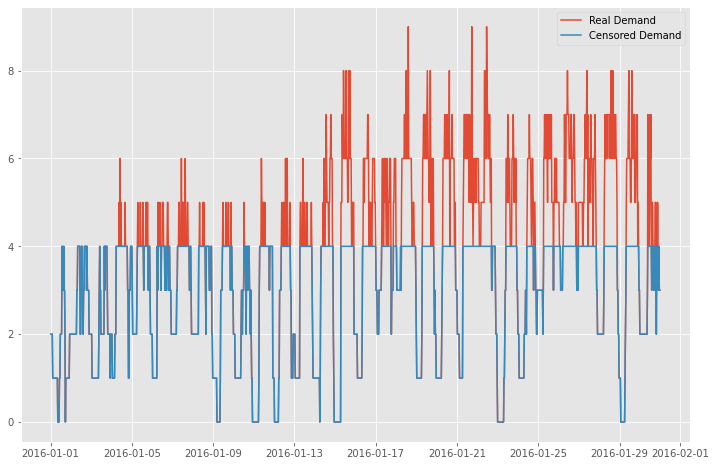

In [9]:
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(12, 8))

df_sample = df[(df.Cluster == 'WEBSTER') & ((df.Period > '2016-01-01') & (df.Period < '2016-01-31'))].copy()
df_sample['Censored'] = df_sample['Sessions'].values

df_sample.loc[df_sample.Sessions > 4, 'Censored'] = 4

plt.plot(df_sample.Period, df_sample.Sessions.values, label='Real Demand')
plt.plot(df_sample.Period, df_sample.Censored.values, label='Censored Demand')
plt.legend()
plt.show()

In [10]:
class AR_Net(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim):
        super(AR_Net, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim) 

        # Non-linearity
        self.relu = nn.ReLU()

        # Linear function (readout)
        self.fc2 = nn.Linear(hidden_dim, output_dim) 

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out
    
class AR(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(AR, self).__init__()
        self.fc1 = nn.Linear(input_dim, output_dim) 

    def forward(self, x):
        out = self.fc1(x)
        return out

In [19]:
input_dim = 48*7
output_dim = 48

X_train = df_sample.reset_index(drop=True).iloc[:input_dim].Sessions.values
y_train = df_sample.reset_index(drop=True).iloc[input_dim:input_dim+output_dim].Sessions.values

model = AR(input_dim, output_dim)

In [20]:
def train_batch(model, x, y, optimizer, loss_fn):
    # Run forward calculation
    y_predict = model.forward(x)

    # Compute loss.
    loss = loss_fn(y_predict, y)

    optimizer.zero_grad()

    loss.backward(retain_graph=True)

    optimizer.step()

    return loss.data.item()


In [21]:
def poissonLoss(predicted, observed):
    """Custom loss function for Poisson model."""
    loss=torch.mean(predicted-observed*torch.log(predicted))
    return loss

Epoch: 0 Loss: 0.9055158495903015
Epoch: 1 Loss: 55.9696044921875
Epoch: 2 Loss: 1.8525115251541138
Epoch: 3 Loss: 5.354768753051758
Epoch: 4 Loss: 3.063121795654297
Epoch: 5 Loss: 4.876251220703125
Epoch: 6 Loss: 6.734940052032471
Epoch: 7 Loss: 8.258892059326172
Epoch: 8 Loss: 9.457276344299316
Epoch: 9 Loss: 10.371819496154785
Epoch: 10 Loss: 11.042312622070312
Epoch: 11 Loss: 11.50740909576416
Epoch: 12 Loss: 11.816912651062012
Epoch: 13 Loss: 12.04885196685791
Epoch: 14 Loss: 12.200179100036621
Epoch: 15 Loss: 12.106472969055176
Epoch: 16 Loss: 11.931517601013184
Epoch: 17 Loss: 11.7839994430542
Epoch: 18 Loss: 11.69589900970459
Epoch: 19 Loss: 11.71695613861084
Epoch: 20 Loss: 12.011923789978027
Epoch: 21 Loss: 12.343265533447266
Epoch: 22 Loss: 12.134357452392578
Epoch: 23 Loss: 11.746325492858887
Epoch: 24 Loss: 11.618386268615723
Epoch: 25 Loss: 11.652156829833984
Epoch: 26 Loss: 11.662086486816406
Epoch: 27 Loss: 11.60177993774414
Epoch: 28 Loss: 11.481520652770996
Epoch: 29 

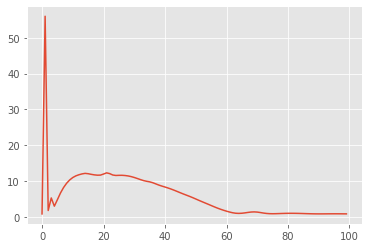

In [45]:
epochs = 100
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.PoissonNLLLoss() 
losses = []
for epoch in range(epochs):
    x = torch.tensor(np.log(X_train+1), dtype=torch.float32).view(1, -1)
    y = torch.tensor(np.log(y_train+1), dtype=torch.float32).view(1, -1)
    loss = train_batch(model, x, y, optimizer, loss_fn)
    losses.append(loss)
    print(f'Epoch: {epoch} Loss: {loss}')
plt.plot(losses)

In [46]:
x = torch.tensor(X_train, dtype=torch.float32).view(1, -1)
y_predict = model.forward(x)
y_predict = y_predict.detach().numpy().reshape(-1)

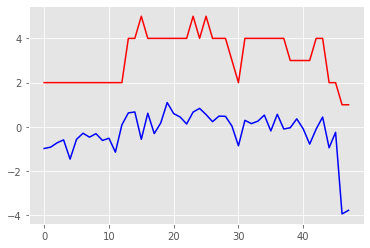

In [47]:
fig, ax = plt.subplots()
ax.plot(y_predict-1, color = 'blue')
ax.plot(y_train, color = 'red')

In [38]:
y_predict

array([ -2.1850538 ,  -4.7174354 , -11.939302  ,  -1.098371  ,
        -0.4883603 ,   0.3542897 ,  -4.6133738 ,   2.775719  ,
         3.9150238 ,   0.79584086,   0.7775525 ,  -1.6962782 ,
         1.2032344 ,   2.5513573 ,  -4.8996315 ,  -0.4103975 ,
         5.951021  ,  -0.2546686 ,   1.148159  ,   3.1726015 ,
        -4.316833  ,  -0.88482326,   3.7747571 ,   4.9045944 ,
         4.2944326 ,  -0.31267133,   5.6336064 ,  -1.8567245 ,
         0.7125371 ,   0.20126307,   1.2503004 ,   4.380727  ,
         1.1329184 ,   2.323322  ,  -1.0877024 ,  -1.7848305 ,
         2.3842404 ,  -0.9536275 ,   0.18966748,   2.747768  ,
         1.0745171 ,  -1.6569015 ,   0.25622377,   2.5047374 ,
        -0.7688249 ,   2.9026403 , -55.361023  , -55.17557   ],
      dtype=float32)

In [32]:
y_train

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 4, 5, 4, 4, 4, 4, 4, 4,
       4, 5, 4, 5, 4, 4, 4, 3, 2, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 4, 4,
       2, 2, 1, 1])

Alternative model

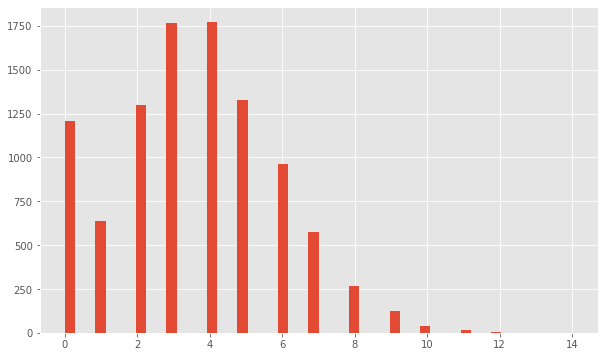

In [125]:
# true distribution parameters
import pytorch_lightning as pl

p_d1 = 0.9
p_lambda = 4

n = 10000
rand_gen = np.random.default_rng(seed=0)

poisson_samples = rand_gen.poisson(lam=p_lambda, size=(n, 1))
mix_samples = rand_gen.binomial(n=1, p=p_d1, size=(n, 1))
rand_samples = mix_samples * poisson_samples

fig, ax = plt.subplots(figsize=(10, 6))
ax.hist(rand_samples, bins=50)
plt.show()

In [145]:
class ZIPModel(pl.LightningModule):
    def __init__(
        self,
        learning_rate=1e-3,
        init_mix_parameter: float = 0.9,
        init_poisson_lambda: float = 4.0,
    ):
    
        super().__init__()
        self.mixture_prob = torch.nn.Parameter(torch.tensor([init_mix_parameter]))
        self.poisson_lambda = torch.nn.Parameter(torch.tensor([init_poisson_lambda]))

        self.train_log_error = []
        self.val_log_error = []
        self.mixture_prob_log = []
        self.poisson_lambda_log = []
        self.learning_rate = learning_rate

    def forward(self):
        # ensure correct domain for params
        mixture_prob_norm = torch.sigmoid(self.mixture_prob)
        poisson_lambda_norm = torch.nn.functional.softplus(self.poisson_lambda)
        poisson_lambda_norm = torch.concat(
            (torch.tensor([0.0]), poisson_lambda_norm)
        )  # maintains grad

        mix = torch.distributions.Categorical(
            torch.concat((mixture_prob_norm, 1 - mixture_prob_norm))
        )
        poissons = torch.distributions.Poisson(poisson_lambda_norm)

        mixture_dist = torch.distributions.MixtureSameFamily(mix, poissons)
        return mixture_dist

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(
            self.parameters(),
            lr=self.learning_rate,
        )
        
        return optimizer

    def training_step(self, batch, batch_idx):
        y = batch[0]

        mixture_dist = self.forward()

        negloglik = -mixture_dist.log_prob(y)
        loss = torch.mean(negloglik)

        self.train_log_error.append(loss.detach().numpy())
        self.poisson_lambda_log.append(
            torch.nn.functional.softplus(self.poisson_lambda).detach().numpy()
        )
        self.mixture_prob_log.append(torch.sigmoid(self.mixture_prob).detach().numpy())
        return loss

    def validation_step(self, batch, batch_idx):
        y = batch[0]

        mixture_dist = self.forward()

        negloglik = -mixture_dist.log_prob(y)
        loss = torch.mean(negloglik)

        self.train_log_error.append(loss.detach().numpy())
        return loss


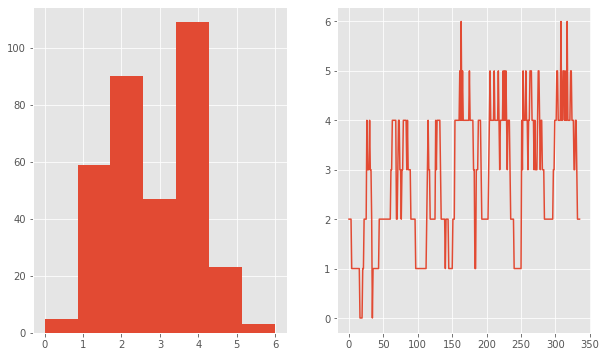

In [146]:
fig, ax = plt.subplots(1,2, figsize=(10, 6))
ax[0].hist(X_train, bins=7)
ax[1].plot(X_train)
plt.show()

In [147]:
torch.manual_seed(4)
model = ZIPModel(learning_rate=1e-0, init_mix_parameter=0.0, init_poisson_lambda=4.0)

(array([55.,  2.,  6., 10.,  7., 14.,  3.,  1.,  1.,  1.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.],
       dtype=float32),
 <BarContainer object of 10 artists>)

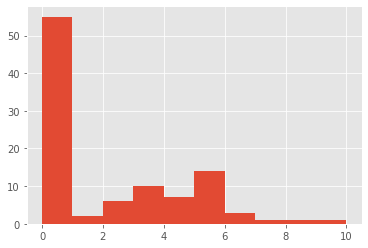

In [148]:
plt.hist(output_dist.sample((100, 1)).numpy())

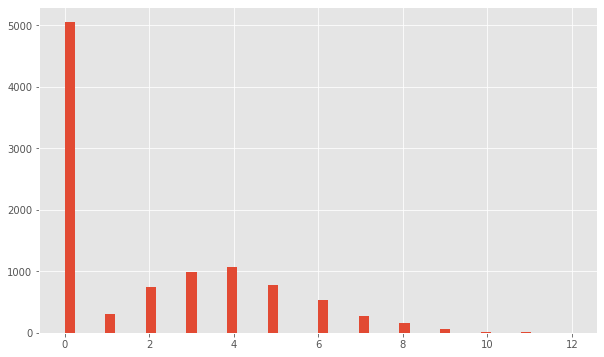

In [149]:
output_dist = model()
output_samples = output_dist.sample((n, 1)).numpy().squeeze()

fig, ax = plt.subplots(figsize=(10, 6))
ax.hist(output_samples, bins=50)
plt.show()

In [150]:
from torch.utils.data import TensorDataset, DataLoader

rand_samples_t = torch.Tensor(X_train)
dataset_train = TensorDataset(rand_samples_t)
dataloader_train = DataLoader(dataset_train, batch_size=len(rand_samples))

# test loading a batch
rand_samples_batch = next(iter(dataloader_train))
rand_samples_batch[0].shape

torch.Size([336])

In [151]:
trainer = pl.Trainer(
    max_epochs=1000,
)
trainer.fit(model, dataloader_train)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/miniconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:108: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(

  | Name | Type | Params
------------------------------
------------------------------
2         Trainable params
0         Non-trainable params
2         Total params
0.000     Total estimated model params size (MB)
/opt/miniconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/opt/miniconda3/lib/

Epoch 999: 100%|██████████| 1/1 [00:00<00:00, 119.66it/s, loss=1.75, v_num=5]

`Trainer.fit` stopped: `max_epochs=1000` reached.


Epoch 999: 100%|██████████| 1/1 [00:00<00:00, 81.72it/s, loss=1.75, v_num=5] 


/var/folders/zw/yys6vm7506q010fwbsz_3djr0000gn/T/ipykernel_2694/492566248.py:11: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


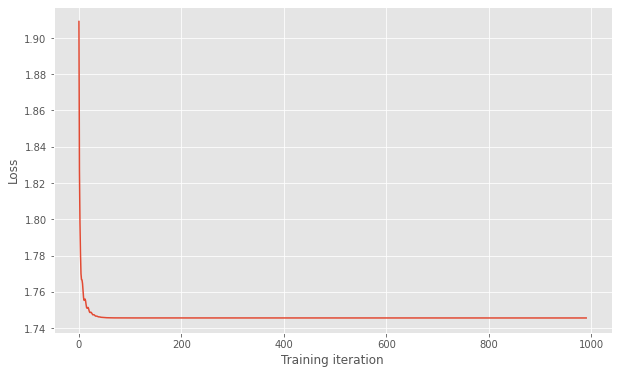

In [152]:
def moving_average(a, n=10):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1 :] / n


fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(moving_average(np.array(model.train_log_error)))
ax.set_ylabel("Loss")
ax.set_xlabel("Training iteration")
fig.show()

/var/folders/zw/yys6vm7506q010fwbsz_3djr0000gn/T/ipykernel_2694/2646926644.py:9: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


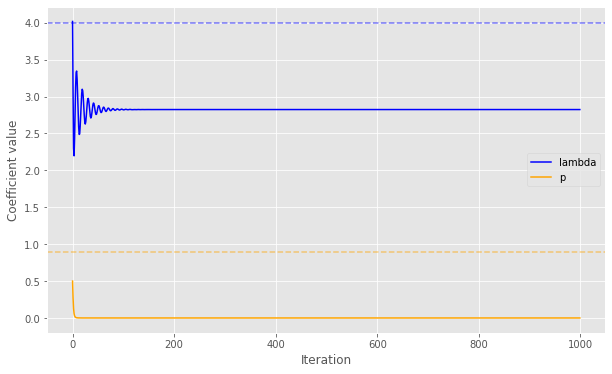

In [153]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(model.poisson_lambda_log, color="b", label="lambda")
ax.plot(model.mixture_prob_log, color="orange", label="p")
ax.axhline(y=p_lambda, linestyle="--", color="b", alpha=0.5)
ax.axhline(y=p_d1, linestyle="--", color="orange", alpha=0.5)
ax.legend()
ax.set_xlabel("Iteration")
ax.set_ylabel("Coefficient value")
fig.show()

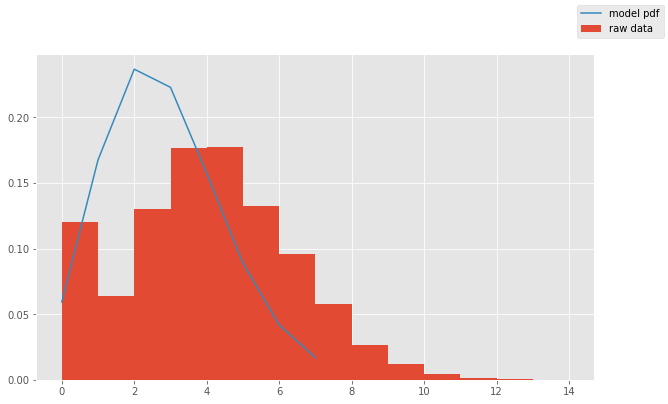

In [154]:
output_dist = model()
x = torch.arange(0, 8)
y = torch.exp(output_dist.log_prob(x))

fig, ax = plt.subplots(figsize=(10, 6))
ax.hist(
    rand_samples,
    bins=rand_samples.max() - rand_samples.min(),
    density=True,
    label="raw data",
)
ax.plot(x.detach().numpy(), y.detach().numpy(), label="model pdf")
fig.legend()
plt.show()